# Init

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/dashboards/')
import warnings
warnings.filterwarnings('ignore')

from cellMix_coordinator import CellMixCoordinator

import exploration_plots
import dashs

import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

import os

from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [2]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20150208_mixture_proteinGroups.xls'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'))


cmc = CellMixCoordinator()
def _calc_and_display_with_cellmix(_a,_b,X,with_cellMix = False,as_heatmap = False) : 
    if _a.empty :
        raise Exception("A is empty")
    if _b.empty :
        raise Exception("B is empty")
    
    cell_abundance_over_samples = CellProportions.fit_as_df(_a,_b)
    
    if with_cellMix : 
        cellMax_cell_abundance_over_samples = cmc.cell_prop_with_bash(_b,_a).rename({"Unnamed: 0":"cells"},axis=1).set_index("cells")
        if as_heatmap : 
            sns.heatmap(cellMax_cell_abundance_over_samples)
            plt.show()
        else :
            display(HTML(' <span style="color:blue"><h1>cellMix : </h1> </span>  '))
            display(cellMax_cell_abundance_over_samples)
    
    if as_heatmap : 
        sns.heatmap(cell_abundance_over_samples)
    else : 
        display(HTML(' <span style="color:blue"><h1>model : </h1> </span>  '))
        display(cell_abundance_over_samples)
        display(HTML(' <span style="color:blue"><h1>known cell proportion : </h1> </span>  '))
        display(X)

        
data_factory = DataFactory(data_loader)
profile_data,profile_data_relvent_data = data_factory.build_cell_specific_profile(intensity_type='Intensity')
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(intensity_type='Intensity')

cell_proportions_df = pd.DataFrame(index = ['Intensity NOT_CD4TCellTcm_01','Intensity NOT_BCellmemory_01','Intensity NOT_Monocytesnonclassical_01'],
                                   columns = list(range(1,9)),
                                   data =np.array(((1,0,0),(0,1,0),(0,0,1),(0.33,0.33,0.33),(0.25,0.25,0.50),(0.25,0.50,0.25),(0.50,0.25,0.25),(0.475,0.475,0.05))).T)

# index_func = lambda x:x.split(';')[0]
index_func = lambda x:x
_profile_data,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data,mixtures,index_func=index_func)
A = _profile_data[profile_data_relvent_data]
B = _mixtures[mixtures_relvent_data]
X = cell_proportions_df


B=B.rename({f:f.split('Intensity ')[1] for f in B.columns},axis=1)

X = X.rename({f:f.split('Intensity ')[1] for f in X.index},axis=0)
X = X.rename({f:'mixture'+str(f) for f in X.columns},axis=1)

A = A.rename({f:f.split('Intensity ')[1] for f in A.columns},axis=1)

### _iBAQ
profile_data_iBAQ,profile_data_relvent_data_iBAQ = data_factory.build_cell_specific_profile(intensity_type='iBAQ')
mixtures_iBAQ,mixtures_relvent_data_iBAQ = data_factory.build_mixture_data(intensity_type='iBAQ')

cell_proportions_df_iBAQ = pd.DataFrame(index = ['iBAQ NOT_CD4TCellTcm_01','iBAQ NOT_BCellmemory_01','iBAQ NOT_Monocytesnonclassical_01'],
                                   columns = list(range(1,9)),
                                   data =np.array(((1,0,0),(0,1,0),(0,0,1),(0.33,0.33,0.33),(0.25,0.25,0.50),(0.25,0.50,0.25),(0.50,0.25,0.25),(0.475,0.475,0.05))).T)

# index_func = lambda x:x.split(';')[0]
index_func = lambda x:x
_profile_data_iBAQ,_mixtures_iBAQ = PP_base.return_mutual_proteins_by_index(profile_data_iBAQ,mixtures_iBAQ,index_func=index_func)
A_iBAQ = _profile_data_iBAQ[profile_data_relvent_data_iBAQ]
B_iBAQ = _mixtures_iBAQ[mixtures_relvent_data_iBAQ]
X_iBAQ = cell_proportions_df_iBAQ


B_iBAQ=B_iBAQ.rename({f:f.split('iBAQ ')[1] for f in B_iBAQ.columns},axis=1)

X_iBAQ = X_iBAQ.rename({f:f.split('iBAQ ')[1] for f in X_iBAQ.index},axis=0)
X_iBAQ = X_iBAQ.rename({f:'mixture'+str(f) for f in X_iBAQ.columns},axis=1)

A_iBAQ = A_iBAQ.rename({f:f.split('iBAQ ')[1] for f in A_iBAQ.columns},axis=1)

# cell signatures(pure tissues) analysis - iBAQ

### cell signatures vs known cell proportions vs mixtures signatures

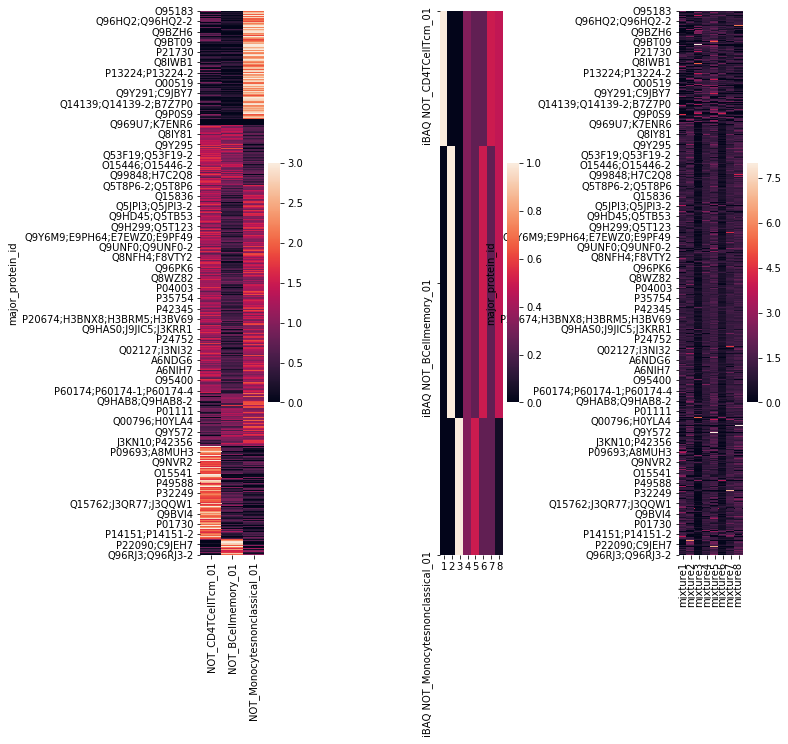

In [3]:
import scipy.cluster.hierarchy as sch

def cells_profiles(A,cell_proportions_df = None,B = None):
    n_var = len([1 for i in locals().values() if i is not None])

    res= (A.T/A.mean(axis=1)).T
    res[A==0]=0

    d = sch.distance.pdist(res) 
    L = sch.linkage(res, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')
    indexes = [res.index.tolist()[i] for i in list((np.argsort(ind)))]
    df = res.reindex(indexes, axis=0)

    args = plt.subplots(1, n_var)
    args[0].set_figheight(10)
    args[0].set_figwidth(10)
    
    if n_var >1 :
        sns.heatmap(df,ax=args[1][0])
    else :
        sns.heatmap(df,ax=args[1])

    if cell_proportions_df is not None : 
        sns.heatmap(cell_proportions_df,ax=args[1][1])

    if B is not None:
        B_ordered = B.copy(deep=True).T/B.mean(axis=1) 
        B_ordered[B.T==0] = 0
        B_ordered = B_ordered.T.reindex(indexes)
        sns.heatmap(B_ordered,ax=args[1][2])
    plt.subplots_adjust(wspace = 2)

cells_profiles(A_iBAQ,cell_proportions_df_iBAQ,B_iBAQ)

### histogram per cell signature  log2(1+x)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


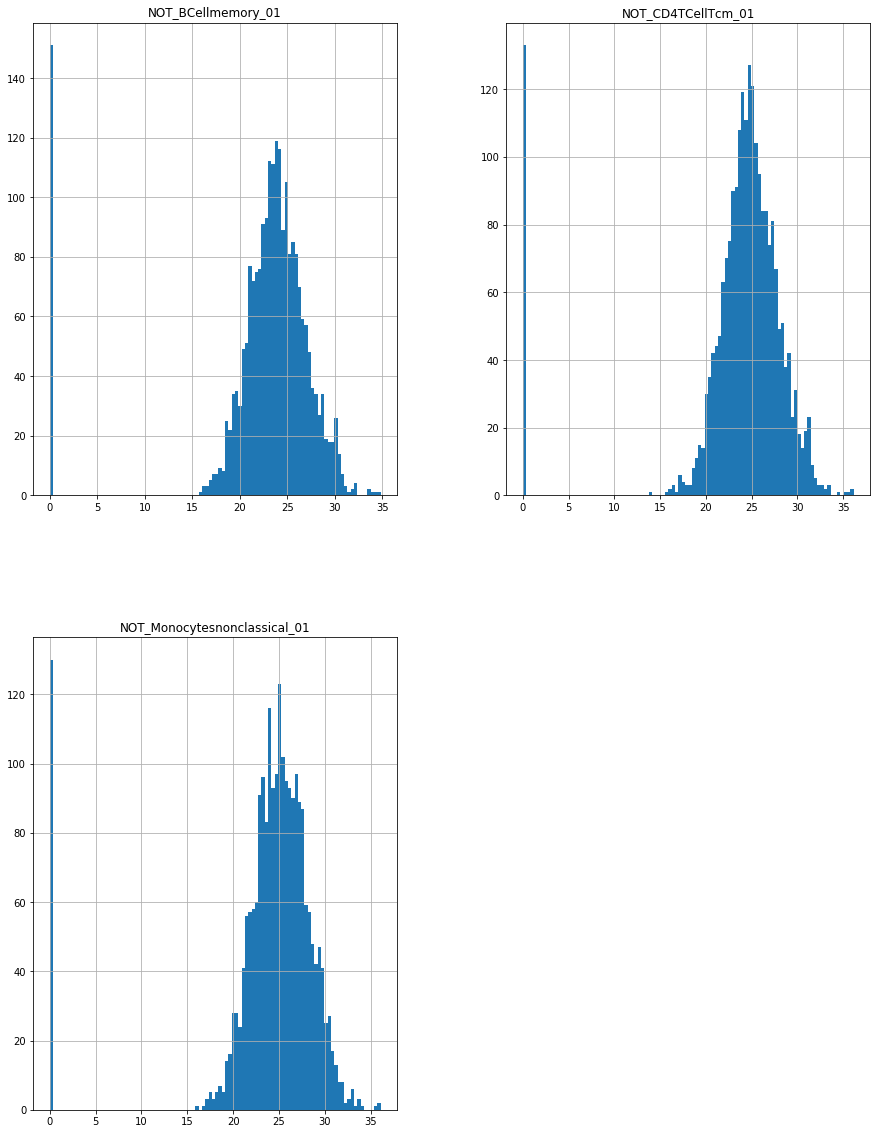

In [4]:
def values_histogram_per_cell_profile(A):
    fig = plt.figure(figsize = (15,20))
    ax = fig.gca()
    ax.set_xlabel("log2(1+x)")
    np.log2(A+1).hist(bins=100,ax=ax)
values_histogram_per_cell_profile(A_iBAQ)

# mixtures signatures analysis

### correlation between mixtures signatures and expected mixtures signatures - Pearson
expected mixtures signatures = cell signature * known proportions
we took the correlation at every percentile(0.8 = top 20%)

In [5]:
def corr_expcted_vs_mixture(expcted_b,B,method  = "pearson"):
    corr_per_mixture_df = pd.DataFrame(index= B.columns)

    for i in np.linspace(0.05,0.95,19) :
        trh = round(i,2)

        for mixture_idx in B:
            mixture =np.log2(B[mixture_idx])
            mixture = B[mixture_idx]
            mixture[B[mixture_idx] == 0] = 0
            mixture_trh = mixture.quantile(trh)
            relevant_proteins = mixture[mixture>mixture_trh].index

            _expcted_b = np.log2(expcted_b[mixture_idx])
            _expcted_b = expcted_b[mixture_idx]
            _expcted_b[expcted_b[mixture_idx] ==0] = 0
            corr = _expcted_b.loc[relevant_proteins].corr(mixture.loc[relevant_proteins],method = method)
            corr_per_mixture_df.ix[mixture_idx,trh] = corr
    corr_per_mixture_df.T.plot(title=f"correlation mixture vs expcted_mixture - {method}")
    plt.xlabel("percentage")

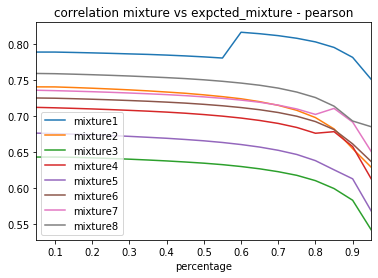

In [6]:
expcted_b = A.dot(X)
corr_expcted_vs_mixture(expcted_b.copy(deep=True),B.copy(deep=True))

### correlation between mixtures signatures and expected mixtures signatures - spearman
expected mixtures signatures = cell signature * known proportions

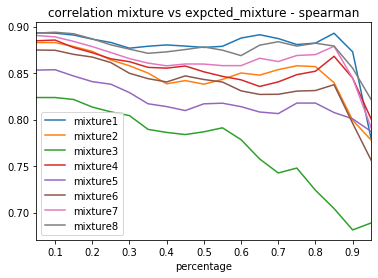

In [7]:
corr_expcted_vs_mixture(expcted_b,B,"spearman")

### number of unexpected zeros - not zero in the expected signatures but zero in the mixtures
x axis  - the number of mixtures where the gene is zero (but not in the expected signatures)

529

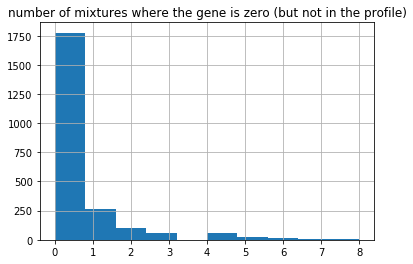

In [8]:
def unexpcted_zeros_per_mixture(expcted_b,B) : 
    number_of_unexpcted_zeros = ((expcted_b != 0)&(B==0)).sum(axis=1)
    display((number_of_unexpcted_zeros >0).sum())
    display(number_of_unexpcted_zeros.hist())
    plt.title("number of mixtures where the gene is zero (but not in the profile)")
    plt.show()
unexpcted_zeros_per_mixture(expcted_b,B)

### scatter expected mixtures signatures vs mixtures signatures


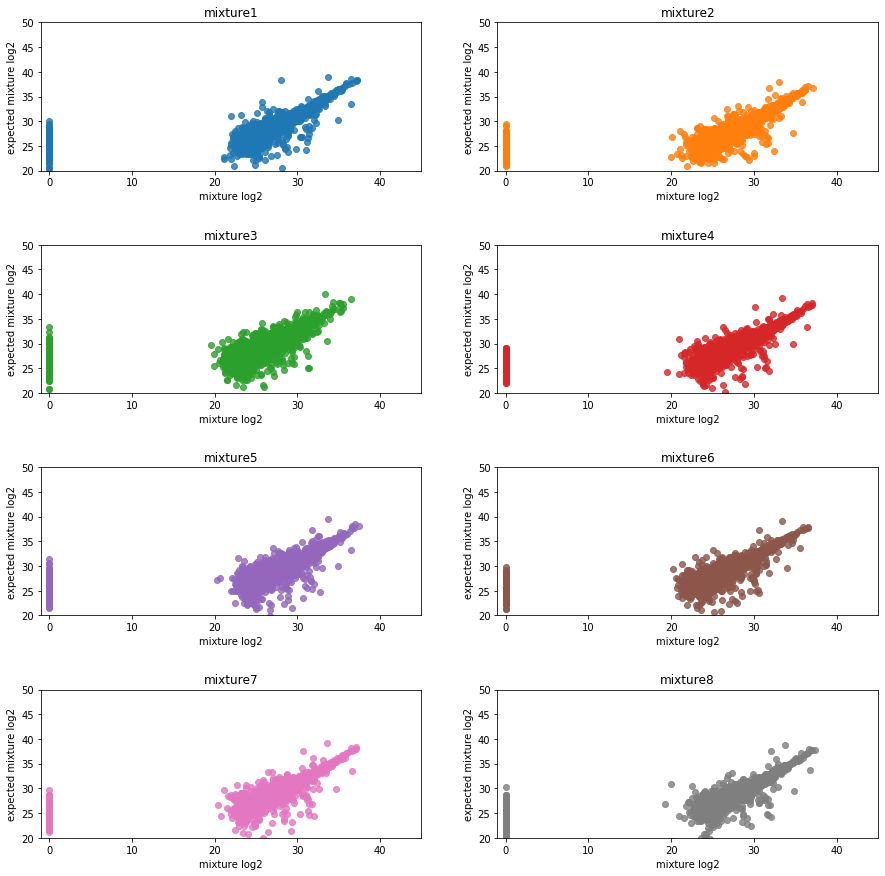

In [9]:
def scatter_mixture_vs_expcted_mixture(expcted_mixture,B):
    fig,axs = plt.subplots(4,2,figsize=(15,15))
    
    for mixture_idx,ax in zip(B,axs.reshape(-1)):
        mixture =np.log2(1+B[mixture_idx])
        expcted_mixture = np.log2(expcted_b[mixture_idx])

        sns.regplot(mixture,expcted_mixture,ax=ax)
        ax.set_ylim(20,50)
        ax.set_xlim(-1,45)
        ax.set_title(mixture_idx)
        ax.set_xlabel( "mixture log2")
        ax.set_ylabel ("expected mixture log2")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

scatter_mixture_vs_expcted_mixture(expcted_b,B)

### histogram of the expected values of unexpected zeros(in the mixture) vs all expected values - normalization using the regression slope 

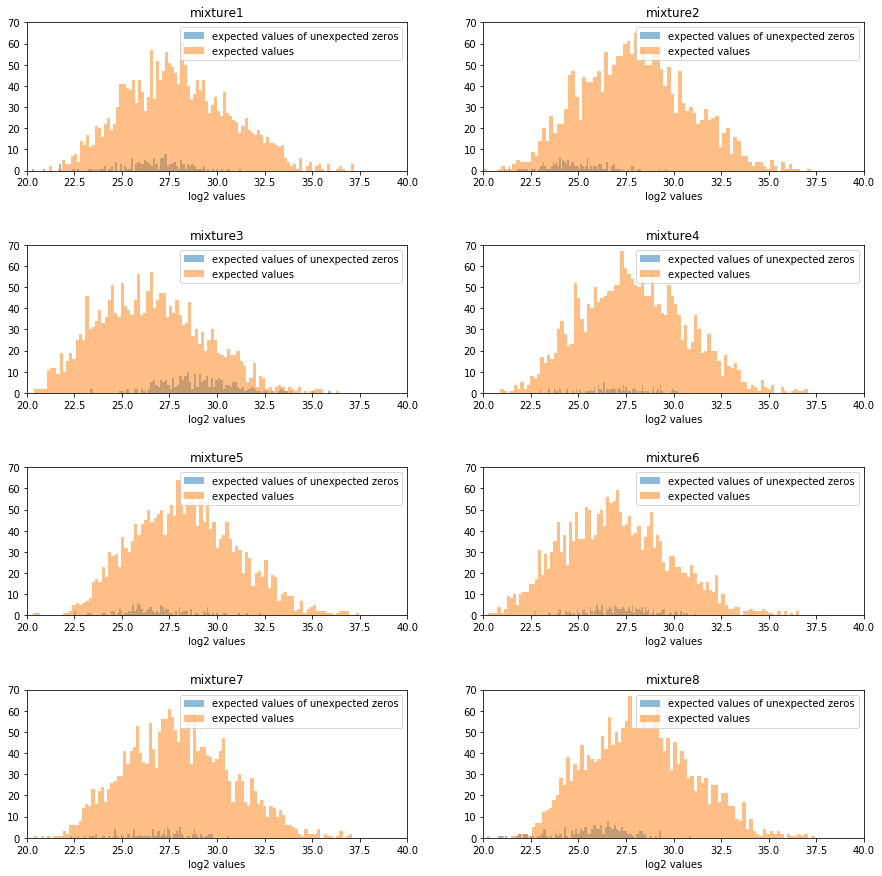

In [10]:
def expected_values_of_unexpected_zeros(expcted_b,B):
    fig,axs = plt.subplots(4,2,figsize=(15,15))

    for mixture_idx,ax in zip(B,axs.reshape(-1)):
        x=B[mixture_idx]
        y=expcted_b[mixture_idx]
        
        x=x[x>0]
        y=y[y>0]
        non_zero_idx = x.index.intersection(y.index) 
        
        x=x.loc[non_zero_idx].values
        y=y.loc[non_zero_idx].values
        
        X = x - x.mean()
        Y = y - y.mean()
        slope = (X.dot(Y)) / (X.dot(X))
       
        zeros = np.log2(1+slope*expcted_b[mixture_idx][((expcted_b[mixture_idx] != 0)&(B[mixture_idx]==0))])
        all_data = np.log2(1+B[mixture_idx][B[mixture_idx] != 0])

        ax.hist(zeros, 100, alpha=0.5, label="expected values of unexpected zeros")
        ax.hist(all_data, 100, alpha=0.5, label="expected values")
        ax.set_xlim(20,40)
        ax.set_ylim(0,70)
        ax.set_title(mixture_idx)
        ax.set_xlabel("log2 values")
        ax.legend(loc = "upper right")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
expected_values_of_unexpected_zeros(expcted_b.copy(deep=True),B.copy(deep=True))

### histogram of the expected values of unexpected zeros(in the mixture) vs all expected values - normalization per protein across samples 

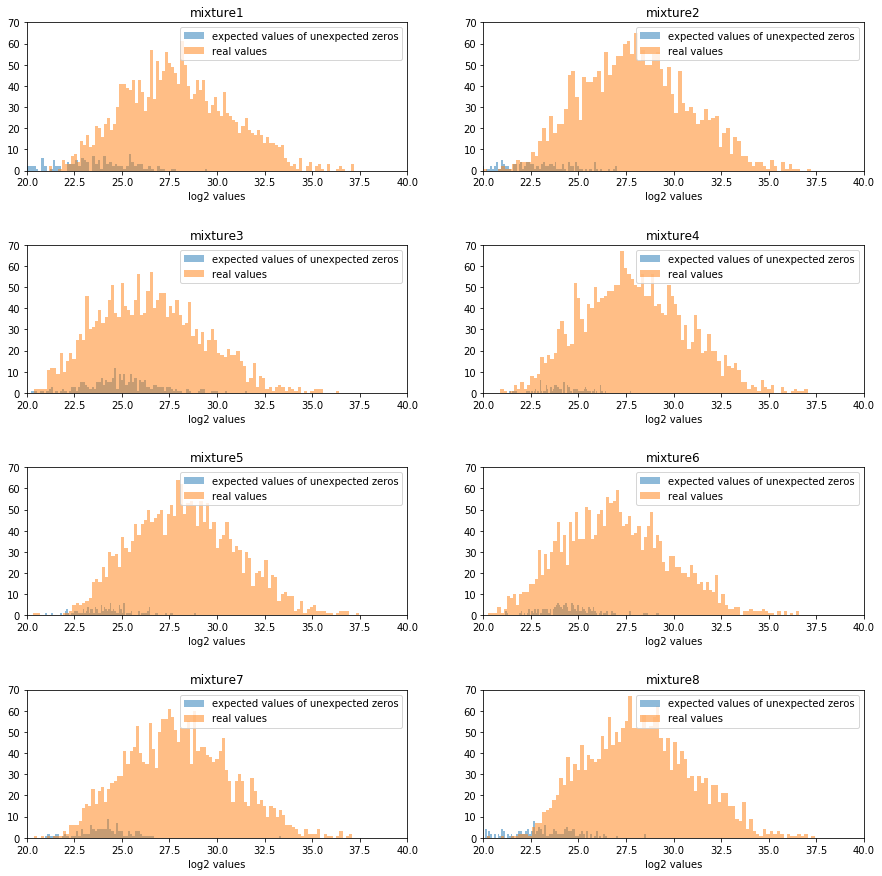

In [11]:
from scipy.stats import linregress
def expected_values_of_unexpected_zeros(expcted_b,B):
    fig,axs = plt.subplots(4,2,figsize=(15,15))
    
    B = B[B>B.quantile(0.01)]
    expcted_b = expcted_b[expcted_b>expcted_b.quantile(0.01)]

    protein_to_slope =  (B/expcted_b).mean(axis=1).fillna(1)
    expcted_b = expcted_b.multiply(protein_to_slope,axis=0).fillna(0)
    B = B.fillna(0)

    unexpcted_zeros_list = []
    for mixture_idx,ax in zip(B,axs.reshape(-1)):
        zeros = np.log2(1+expcted_b[mixture_idx][((expcted_b[mixture_idx] != 0)&(B[mixture_idx]==0))])
        unexpcted_zeros_list += zeros.index.tolist()
        all_data = np.log2(1+B[mixture_idx][B[mixture_idx] != 0])
        ax.hist(zeros, 100, alpha=0.5, label="expected values of unexpected zeros")
        ax.hist(all_data, 100, alpha=0.5, label="real values")
        ax.set_xlim(20,40)
        ax.set_ylim(0,70)
        ax.set_title(mixture_idx)
        ax.set_xlabel("log2 values")
        ax.legend(loc = "upper right")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    return unexpcted_zeros_list
unexpcted_zeros_list = expected_values_of_unexpected_zeros(expcted_b.copy(deep=True),B.copy(deep=True))

In [12]:
from collections import Counter
c_zeros = Counter(unexpcted_zeros_list)
total_zeros_across_mixtures = pd.DataFrame(c_zeros.most_common()).rename(columns = {0:"major proteins",1:"number of mixtures"}).set_index("major proteins")
total_zeros_across_mixtures[total_zeros_across_mixtures>5].dropna()

,number of mixtures
major proteins,
O00391;O00391-2,8.0
Q16222;Q16222-2;Q16222-3,8.0
Q5T8I3;Q5T8I3-2,8.0
Q8IZ21;Q8IZ21-3;Q8IZ21-2,8.0
Q8N2W9,8.0
Q9P1Z0,8.0
O00425,7.0
Q14964,7.0
Q5F1R6;Q5F1R6-3;Q5F1R6-2,7.0


# results analysis

### no preprocessing

In [13]:
_calc_and_display_with_cellmix(A,B,X,True)

,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
cells,,,,,,,,
NOT_CD4TCellTcm_01,1,0.618582,0.670051,1,1,1,1,1
NOT_BCellmemory_01,0,0.381418,0.000000,0,0,0,0,0
NOT_Monocytesnonclassical_01,0,0.000000,0.329949,0,0,0,0,0


,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
NOT_CD4TCellTcm_01,1.0,0.62,0.67,1.0,1.0,1.0,1.0,1.0
NOT_BCellmemory_01,0.0,0.38,0.00,0.0,0.0,0.0,0.0,0.0
NOT_Monocytesnonclassical_01,0.0,0.00,0.33,0.0,0.0,0.0,0.0,0.0


,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
NOT_CD4TCellTcm_01,1.0,0.0,0.0,0.33,0.25,0.25,0.50,0.475
NOT_BCellmemory_01,0.0,1.0,0.0,0.33,0.25,0.50,0.25,0.475
NOT_Monocytesnonclassical_01,0.0,0.0,1.0,0.33,0.50,0.25,0.25,0.050


### zero based- keep protein with zero in at least one signature 
keep proteins with less then 8 occurrences in B
keep proteins with less then 3 occurrences in A

In [14]:
_A,_B = PP_proteins.pp_clean_irrelevant_proteins(A,B)
_A,_B = PP_proteins.pp_naive_discriminative_proteins(_A,_B)

_calc_and_display_with_cellmix(_A,_B,X,True)

,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
cells,,,,,,,,
NOT_CD4TCellTcm_01,0.886009,0.000000,0,0.35151,0.085645,0.488041,0.626470,0.323817
NOT_BCellmemory_01,0.113855,0.994233,0,0.42537,0.685488,0.003946,0.212074,0.663364
NOT_Monocytesnonclassical_01,0.000137,0.005767,1,0.22312,0.228867,0.508014,0.161457,0.012819


,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
NOT_CD4TCellTcm_01,0.89,0.00,0.0,0.35,0.09,0.49,0.63,0.32
NOT_BCellmemory_01,0.11,0.99,0.0,0.43,0.69,0.00,0.21,0.66
NOT_Monocytesnonclassical_01,0.00,0.01,1.0,0.22,0.23,0.51,0.16,0.01


,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
NOT_CD4TCellTcm_01,1.0,0.0,0.0,0.33,0.25,0.25,0.50,0.475
NOT_BCellmemory_01,0.0,1.0,0.0,0.33,0.25,0.50,0.25,0.475
NOT_Monocytesnonclassical_01,0.0,0.0,1.0,0.33,0.50,0.25,0.25,0.050


### binary occurrence - zero stays zero ,everything else in one 

In [15]:
_A,_B = PP_proteins.pp_clean_irrelevant_proteins(A,B)
_A,_B = PP_proteins.pp_binary_occurrence(_A,_B)

_calc_and_display_with_cellmix(_A,_B,X)

,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
NOT_CD4TCellTcm_01,0.77,0.24,0.03,0.33,0.26,0.29,0.37,0.41
NOT_BCellmemory_01,0.18,0.61,0.29,0.30,0.33,0.23,0.33,0.38
NOT_Monocytesnonclassical_01,0.05,0.15,0.69,0.37,0.41,0.48,0.30,0.21


,mixture1,mixture2,mixture3,mixture4,mixture5,mixture6,mixture7,mixture8
NOT_CD4TCellTcm_01,1.0,0.0,0.0,0.33,0.25,0.25,0.50,0.475
NOT_BCellmemory_01,0.0,1.0,0.0,0.33,0.25,0.50,0.25,0.475
NOT_Monocytesnonclassical_01,0.0,0.0,1.0,0.33,0.50,0.25,0.25,0.050
